Simulate S1 condition (small slice size and large slice numbers)

In [1]:
import scanpy as sc 
import anndata as ad 

adata = sc.read_h5ad('merfish_control.h5ad')

new_adata = ad.concat([adata] * 100, label='slice_id')

new_adata.obs['condition'] = 1

new_adata.obs['condition'][new_adata.obs['slice_id'] != '0'] = 0

new_adata.obs['cell_type'] = new_adata.obs['cell_class'].astype(str).values 

new_adata.obs['cell_type'][new_adata.obs['slice_id'] == '0'] = 'novel'


/home/cuiyan/miniconda3/envs/tc/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_1762150/3359232000.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pand

Simulate S2 condition (large slice size and small slice numbers)

In [1]:
import pysodb
import anndata as ad 
import scanpy as sc

#sodb = pysodb.SODB()
#adata_dict = sodb.load_dataset('Dataset13_MS_raw')
#adata = list(adata_dict.values())[0]


adata = sc.read_h5ad('merscope_test.h5ad')

new_adata = ad.concat([adata] * 2, label='slice_id')

new_adata.obs['condition'] = 1

new_adata.obs['condition'][new_adata.obs['slice_id'] != '0'] = 0

new_adata.obs['cell_type'] = new_adata.obs['ct'].astype(str).values 

new_adata.obs['cell_type'][new_adata.obs['slice_id'] == '0'] = 'novel'

/home/cuiyan/miniconda3/envs/stagate/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_1740089/206793181.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
import time
from Taichi.model import Taichi


import scanpy as sc 
import time
import numpy as np
import anndata as ad

start_time = time.time()

model = Taichi(new_adata, ct_obs='cell_type', slice_id='slice_id')

model.mender_init(scale=4, radius=15, nn_mode='radius')

model.run_mender(n_process=200)

model.label_refinement()

res = model.graph_diffusion()

res = res[res.obs['condition'] == 1]

end_time = time.time()

print(f'Total Running Time {end_time - start_time}')

In [ ]:
import STAGATE_pyG as STAGATE 
import scanpy as sc 
import anndata as ad
import pandas as pd
import numpy as np 
import time

adata_list = []

for slice in new_adata.obs['slice_id'].unique():
    adata_list.append(new_adata[new_adata.obs['slice_id'] == slice].copy())

def stagate(adata_list):
    for adata in adata_list:
        STAGATE.utils.Cal_Spatial_Net(adata, k_cutoff=60, model='KNN')
    adata = ad.concat(adata_list, label='slice_id')
    adata.uns['Spatial_Net'] = pd.concat([adata_list[i].uns['Spatial_Net'] for i in range(len(adata_list))])
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = STAGATE.Train_STAGATE.train_STAGATE(adata)
    adata = STAGATE.utils.mclust_R(adata, used_obsm='STAGATE', num_cluster=10)
    unique = list(set(adata[adata.obs['condition'] == 1].obs['mclust'].unique()) - set(adata[adata.obs['condition'] == 0].obs['mclust'].unique()))
    res = adata[adata.obs['condition'] == 1].copy()
    res.obs['new'] = np.isin(adata[adata.obs['condition'] == 1].obs['mclust'].values, unique)
    return adata

start_time = time.time()

res = stagate(adata_list)

end_time = time.time()

print(f'Total Running Time {end_time - start_time}')

In [ ]:
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything
import squidpy as sq 
import cellcharter as cc
import time

adata_list = []

for slice in new_adata.obs['slice_id'].unique():
    adata_list.append(new_adata[new_adata.obs['slice_id'] == slice].copy())

def cellcharter(adata_list):
    adata = ad.concat(adata_list, label='slice_id')
    seed_everything(12345)
    scvi.settings.seed = 12345

    adata.layers["counts"] = adata.X.copy()

    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)


    scvi.model.SCVI.setup_anndata(
        adata, 
        layer="counts", 
        batch_key='slice_id',
    )

    model = scvi.model.SCVI(adata)

    model.train(max_epochs=100, enable_progress_bar=True)
    
    adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

    sq.gr.spatial_neighbors(adata, library_key='slice_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)\

    cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='slice_id')
    
    autok = cc.tl.ClusterAutoK(
        n_clusters=(2,10), 
        max_runs=10,
        convergence_tol=0.001
    )
    autok.fit(adata, use_rep='X_cellcharter')

    adata.obs['cluster_cc'] = autok.predict(adata, use_rep='X_cellcharter')

    unique = list(set(adata[adata.obs['condition'] == 1].obs['cluster_cc'].unique()) - set(adata[adata.obs['condition'] == 0].obs['cluster_cc'].unique()))
    res = adata[adata.obs['condition'] == '1'].copy()
    res.obs['new'] = np.isin(adata[adata.obs['condition'] == 1].obs['cluster_cc'].values, unique)
    return adata

start_time = time.time()

res = cellcharter(adata_list)

end_time = time.time()

print(f'Total Running Time {end_time - start_time}')



([<matplotlib.axis.XTick at 0x7fed7d323d10>,
 [Text(10000, 0, '10k (2 slices)'),
  Text(50000, 0, '50k (10 slices)'),
  Text(500000, 0, '500K (100 slices)'),
  Text(5000000, 0, '5M (10000 slices)')])

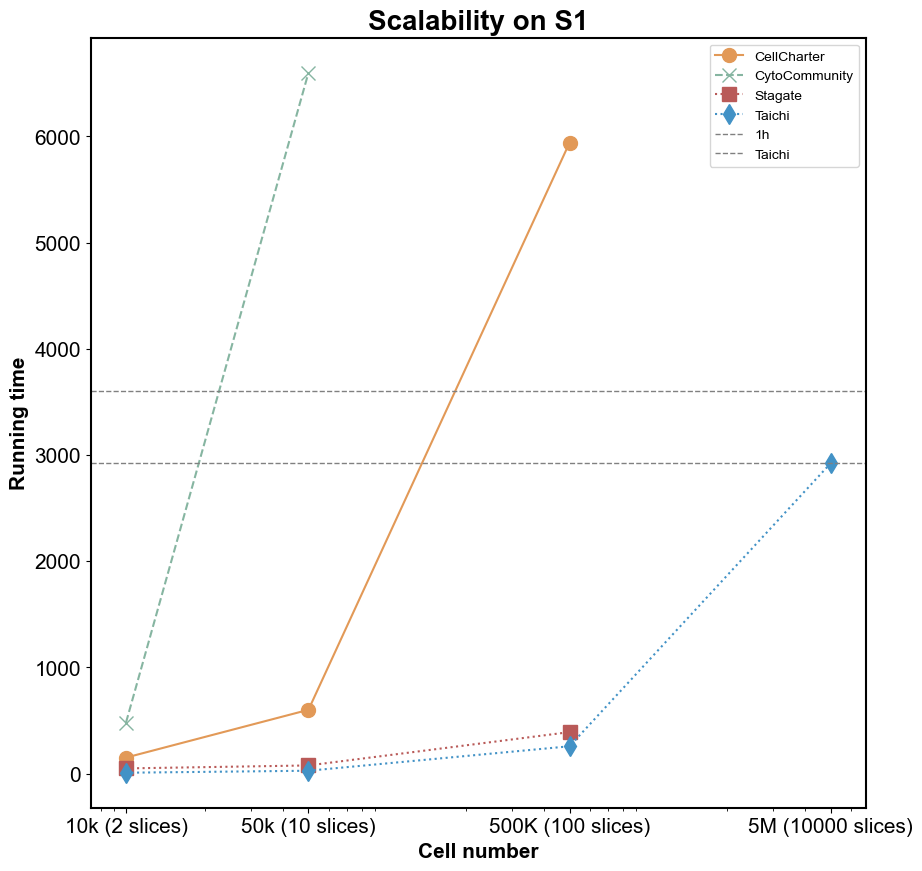

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

colors = ['#4292C6', '#86B5A1', '#B95A58', '#7976A2', '#4A5E65', '#E29957']

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15


# 创建含有缺失值的数据
data = {
    'Cell number': [10000, 50000, 500000, 5000000],
    'CellCharter': [150, 600, 5940, np.nan],
    'CytoCommunity': [480, 6600, np.nan, np.nan],
    'Stagate': [48, 76, 6*60+30, np.nan],
    'Taichi': [7.45, 26.2, 256.4, 2921]
}
df = pd.DataFrame(data)

# 设置绘图风格
# 创建绘图
plt.figure(figsize=(10, 10))

# 为每种方法绘制线图
plt.plot(df['Cell number'], df['CellCharter'], label='CellCharter', marker='o', linestyle='-', color=colors[-1], markersize=10)
plt.plot(df['Cell number'], df['CytoCommunity'], label='CytoCommunity', marker='x', linestyle='--', color=colors[1], markersize=10)
plt.plot(df['Cell number'], df['Stagate'], label='Stagate', marker='s', linestyle=':', color=colors[2], markersize=10)
plt.plot(df['Cell number'], df['Taichi'], label='Taichi', marker='d', linestyle=':', color=colors[0], markersize=10)

plt.axhline(y=3600, color='gray', linestyle='--', linewidth=1.0, label='1h')
plt.axhline(y=2921, color='gray', linestyle='--', linewidth=1.0, label='Taichi')

# 添加图表标题和标签
plt.title('Scalability on S1')
plt.xlabel('Cell number')
plt.ylabel('Running time')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()  # 显示图例

plt.xscale('log', base=10)

ticks = [10000, 50000, 500000, 5000000]
tick_labels = ['10k (2 slices)', '50k (10 slices)', '500K (100 slices)', '5M (10000 slices)']
plt.xticks(ticks, tick_labels)



([<matplotlib.axis.XTick at 0x7fed7d1ffb90>,
 [Text(10000, 0, '10k'), Text(50000, 0, '50k '), Text(500000, 0, '500K')])

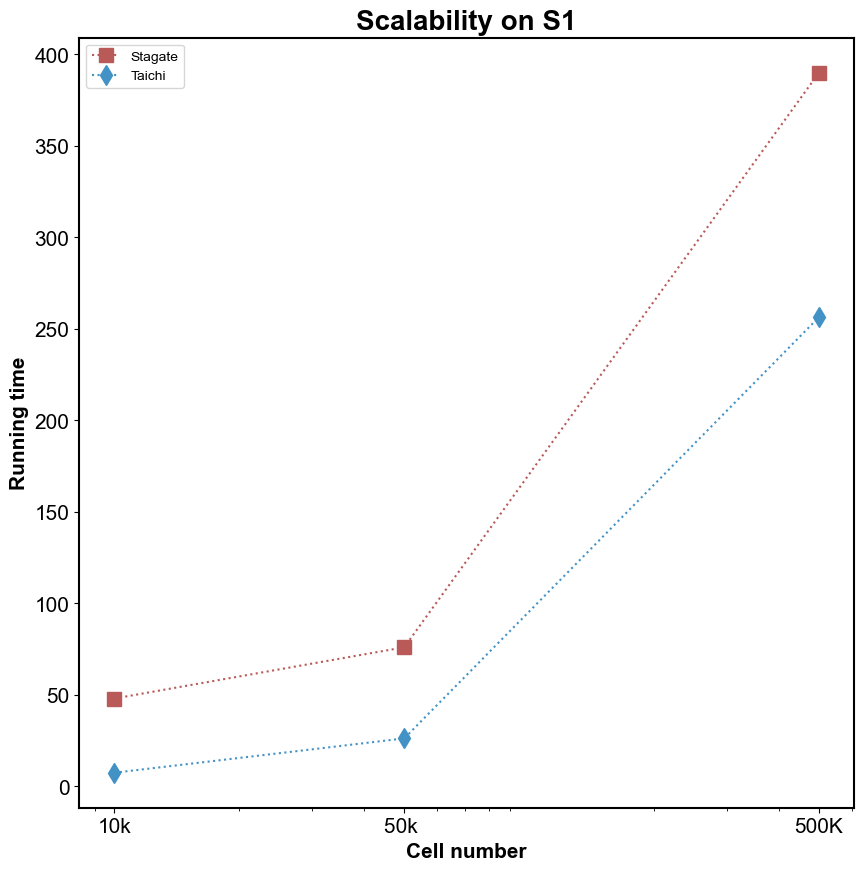

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

colors = ['#4292C6', '#86B5A1', '#B95A58', '#7976A2', '#4A5E65', '#E29957']

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15


# 创建含有缺失值的数据
data = {
    'Cell number': [10000, 50000, 500000],
    'Stagate': [48, 76, 6*60+30],
    'Taichi': [7.45, 26.2, 256.4]
}
df = pd.DataFrame(data)

# 设置绘图风格
# 创建绘图
plt.figure(figsize=(10, 10))


plt.plot(df['Cell number'], df['Stagate'], label='Stagate', marker='s', linestyle=':', color=colors[2], markersize=10)
plt.plot(df['Cell number'], df['Taichi'], label='Taichi', marker='d', linestyle=':', color=colors[0], markersize=10)


# 添加图表标题和标签
plt.title('Scalability on S1')
plt.xlabel('Cell number')
plt.ylabel('Running time')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()  # 显示图例

plt.xscale('log', base=10)

ticks = [10000, 50000, 500000]
tick_labels = ['10k', '50k ', '500K']
plt.xticks(ticks, tick_labels)



([<matplotlib.axis.XTick at 0x7fed7d0b6290>,
 [Text(320000, 0, '320k (2 slices)'),
  Text(1600000, 0, '1.6M (10 slices)'),
  Text(16000000, 0, '16M (100 slices)')])

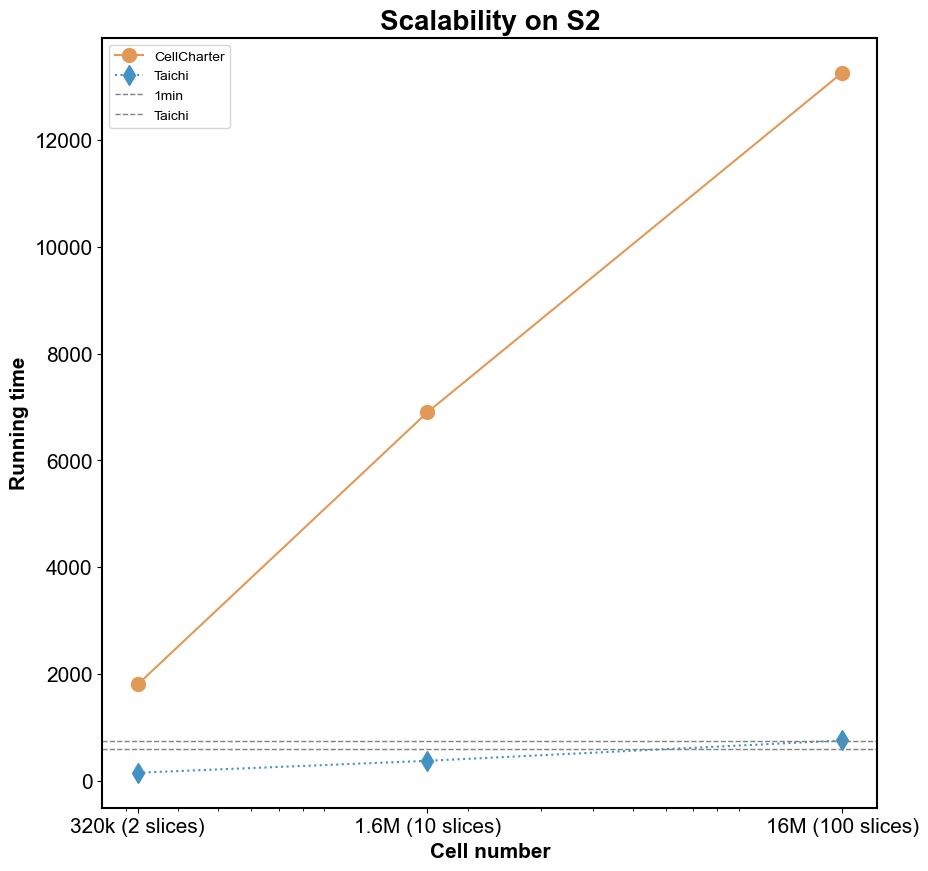

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def million_formatter(x, pos):
    return f'{int(x/1e6)}M'
from matplotlib.ticker import FuncFormatter

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15




colors = ['#4292C6', '#86B5A1', '#B95A58', '#7976A2', '#4A5E65', '#E29957']

# 创建含有缺失值的数据
data = {
    'Cell number': [320000, 1600000, 16000000],
    'CellCharter': [30*60, 115*60, 221*60],
    'Taichi': [147.17,  370.38, 750.83]
}
df = pd.DataFrame(data)

# 设置绘图风格
# 创建绘图
plt.figure(figsize=(10, 10))

# 为每种方法绘制线图
plt.plot(df['Cell number'], df['CellCharter'], label='CellCharter', marker='o', linestyle='-', color=colors[-1], markersize=10)
plt.plot(df['Cell number'], df['Taichi'], label='Taichi', marker='d', linestyle=':', color=colors[0], markersize=10)


plt.axhline(y=600, color='gray', linestyle='--', linewidth=1.0, label='1min')
plt.axhline(y=750, color='gray', linestyle='--', linewidth=1.0, label='Taichi')

# 添加图表标题和标签
plt.title('Scalability on S2')
plt.xlabel('Cell number')
plt.ylabel('Running time')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()  # 显示图例


plt.xscale('log', base=10)
plt.legend()

ticks = [320000, 1600000, 16000000]
tick_labels = ['320k (2 slices)', '1.6M (10 slices)', '16M (100 slices)']
plt.xticks(ticks, tick_labels)
